In [13]:
from support.df_init import init

train = init()
test = init('pp_test.csv')

In [14]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

In [15]:
feats = [
    'is_Documentary',
    # 'is_History', 
    'is_Adventure',
    # 'is_Thriller',
    # 'is_Game-Show',
    'is_Comedy',
    # 'is_Sci-Fi',
    # 'is_Romance',
    # 'is_Biography',
    # 'is_Musical', 'is_Western',
    # 'is_Music', 
    # 'is_Film-Noir',
    'is_Adult',
    'is_Reality-TV',
    # 'is_News',
    # 'is_Action',
    'is_Crime',
    # 'is_Short',
    # 'is_Fantasy',
    'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    # 'is_Sport',
    'is_Horror', 'is_Animation',
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA',
    'countryOfOrigin_AS',
    # 'countryOfOrigin_EU',
    # 'countryOfOrigin_OC',
    # 'countryOfOrigin_SA',
    # 'countryOfOrigin_AF',
    'countryOfOrigin_UNK',
    'criticReviewsTotal', 'userReviewsTotal',

    'numRegions',
    'totalMedia',
    'totalCredits', 
    'totalNominations',
    'rating',
    'startYear',
    'runtimeMinutes_notitletype',
]

In [16]:
train.loc[~train['outlier_no_type'], 'titleType'].unique()


array(['tvEpisode', 'movie', 'tvSeries', 'tvMiniSeries', 'short',
       'tvMovie', 'tvSpecial', 'video'], dtype=object)

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import randint, uniform


# Prepare the data
X_train = train.loc[~train['outlier_no_type'], feats]
y_train = train.loc[~train['outlier_no_type'], 'titleType']

X_test = test.loc[~test['outlier_no_type'], feats]
y_test = test.loc[~test['outlier_no_type'], 'titleType']

# Scale the features


# Define the model
dt = DecisionTreeClassifier(random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(5, 15),
    'min_samples_split': randint(4, 20),
    'min_samples_leaf': randint(5, 20),
    # 'max_features': [None, 'sqrt', 'log2'],
    # 'ccp_alpha': uniform(0.0, 0.01),
}


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=200,
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the model on the training set
y_train_pred = random_search.best_estimator_.predict(X_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_train_pred))

# Evaluate the model on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 6, 'min_samples_split': 8}
Best Score: 0.5061627033784339
Train Set Classification Report:
              precision    recall  f1-score   support

       movie       0.87      0.94      0.90      5442
       short       0.89      0.94      0.92      2382
   tvEpisode       0.89      0.93      0.91      4690
tvMiniSeries       0.52      0.27      0.35       186
     tvMovie       0.61      0.41      0.49       844
    tvSeries       0.78      0.74      0.76      1337
   tvSpecial       0.34      0.16      0.22       158
       video       0.77      0.51      0.61       744

    accuracy                           0.86     15783
   macro avg       0.71      0.61      0.65     15783
weighted avg       0.84      0.86      0.85     15783

Test Set Classification Report:
              precision    recall  f1-score   support

       movie       0.84      0.88      0.86      1848
       short       0.86      0.92     

In [18]:
random_search.best_estimator_.feature_importances_

array([8.40874116e-03, 1.01632074e-02, 8.55875678e-03, 2.31032985e-02,
       6.02927156e-04, 3.97560875e-03, 2.93169904e-03, 4.08025754e-04,
       7.23987452e-04, 9.97670901e-03, 5.93857048e-04, 1.19171388e-02,
       6.06394590e-02, 2.98159909e-03, 1.35450602e-02, 3.18209760e-03,
       1.20256167e-02, 8.24489884e-03, 1.27848765e-01, 3.46081754e-02,
       7.71171498e-02, 2.05280637e-02, 2.53145695e-02, 8.51809109e-02,
       4.47419677e-01])

In [19]:
# from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import numpy as np

# # Get all possible ccp_alphas from the pruning path
# path = random_search.best_estimator_.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas_all = np.unique(path.ccp_alphas)

# # Filter out very small alphas (e.g., below 1e-6)
# ccp_alphas_all = ccp_alphas_all[ccp_alphas_all > 1e-6]

# # Choose approximately 20 evenly spaced alphas from the valid ones
# n_alphas = min(20, len(ccp_alphas_all))  # Don't oversample if there are fewer than 20
# ccp_alphas = np.linspace(ccp_alphas_all.min(), ccp_alphas_all.max(), n_alphas)

# # Optional: Round to make more human-friendly values
# ccp_alphas = np.round(ccp_alphas, decimals=6)

# print(f"Using {len(ccp_alphas)} ccp_alpha values for grid search:")
# print(ccp_alphas)


# # Build a base model without alpha (rest from best params)
# base_params = {k: v for k, v in random_search.best_params_.items() if k != 'ccp_alpha'}
# dt = DecisionTreeClassifier(random_state=42, **base_params)

# # Define cross-validation strategy
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# # Grid search on ccp_alpha
# grid = GridSearchCV(
#     estimator=dt,
#     param_grid={'ccp_alpha': ccp_alphas},
#     cv=cv,
#     scoring='f1_weighted',
#     n_jobs=-1
# )

# grid.fit(X_train, y_train)

# # Plot mean CV scores vs alpha
# mean_scores = grid.cv_results_['mean_test_score']
# plt.figure(figsize=(8, 5))
# plt.plot(ccp_alphas, mean_scores, marker='o')
# plt.xlabel('ccp_alpha')
# plt.ylabel('Mean CV F1-macro')
# plt.title('Cross-Validation: F1-macro vs CCP Alpha')
# plt.grid(True)
# plt.xscale('log')
# plt.show()

# # Best alpha
# best_alpha = grid.best_params_['ccp_alpha']
# print(f"Best ccp_alpha from CV: {best_alpha}")

# # Retrain pruned tree on full training set with selected alpha
# pruned_tree = DecisionTreeClassifier(random_state=42, **base_params, ccp_alpha=best_alpha)
# pruned_tree.fit(X_train, y_train)

# # Final evaluation on test set
# print("Classification report for pruned tree on test set:")
# print(classification_report(y_test, pruned_tree.predict(X_test)))

In [20]:
# n_alphas = min(10, len(ccp_alphas_all))  # Don't oversample if there are fewer than 20
# ccp_alphas = np.linspace(ccp_alphas_all.min(), ccp_alphas_all.max(), n_alphas)

In [21]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
# from sklearn.metrics import classification_report
# import numpy as np

# # Define the model
# dt = DecisionTreeClassifier(random_state=42)


# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 20, 30, 40],
#     'min_samples_split': [2, 6, 10],
#     'min_samples_leaf': [1, 3, 6],
#     'ccp_alpha': ccp_alphas
# }

# # Define cross-validation strategy
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# # Perform GridSearchCV
# grid_search = GridSearchCV(
#     estimator=dt,
#     param_grid=param_grid,
#     scoring='f1_weighted',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score (f1_macro):", grid_search.best_score_)

# # Evaluate the model on the training set
# y_train_pred = grid_search.best_estimator_.predict(X_train)
# print("Train Set Classification Report:")
# print(classification_report(y_train, y_train_pred))

# # Evaluate the model on the test set
# y_pred = grid_search.best_estimator_.predict(X_test)
# print("Test Set Classification Report:")
# print(classification_report(y_test, y_pred))


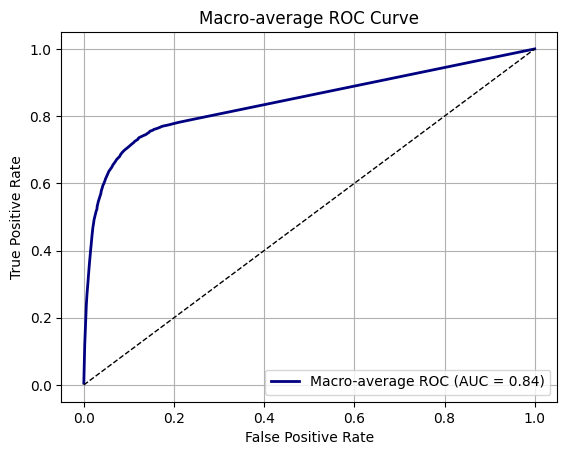

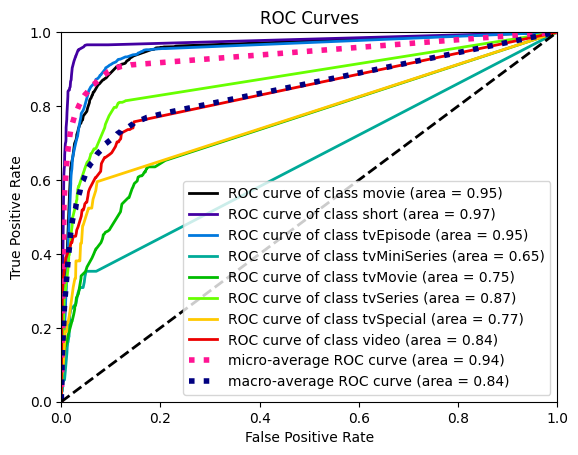

In [22]:
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
# Encode and binarize y_test
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Get predicted probabilities
y_score = random_search.best_estimator_.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color='navy', lw=2, label=f'Macro-average ROC (AUC = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-average ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plot_roc(
    y_test,
    random_search.best_estimator_.predict_proba(X_test)
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

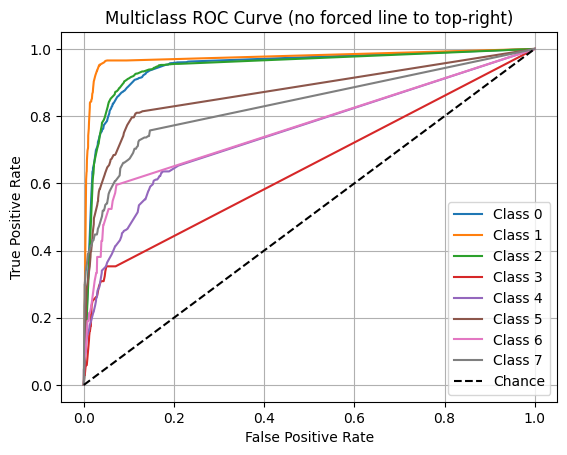

In [23]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities once, not inside the loop
proba = random_search.best_estimator_.predict_proba(X_test)

# Determine number of classes
n_classes = proba.shape[1]

# Binarize the true labels
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

y_bin = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Plot ROC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (no forced line to top-right)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [24]:
import numpy as np
np.save('y_true_dt_multiclass.npy', y_test)
np.save('y_scores_dt_multiclass.npy', random_search.best_estimator_.predict_proba(X_test))

In [25]:
np.save("classes_dt.npy", random_search.best_estimator_.classes_)

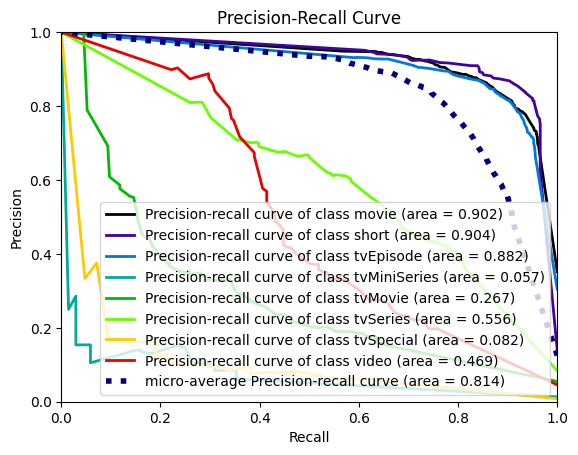

In [26]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(
    y_test,
    random_search.best_estimator_.predict_proba(X_test)
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

<Figure size 400x400 with 0 Axes>

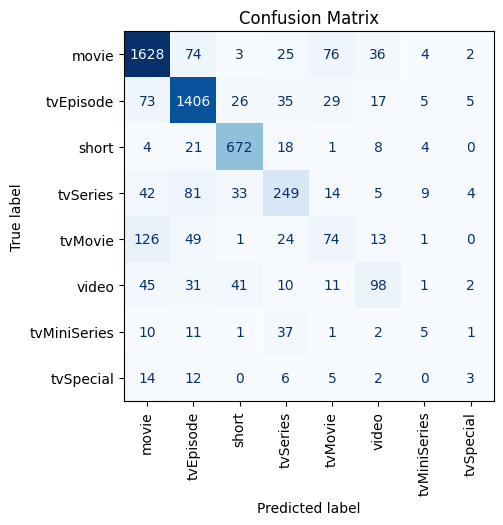

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Order classes by their representation in y_test (descending)
class_counts = Counter(y_test)
classes = np.array([c for c, _ in class_counts.most_common()])

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(4,4))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)
plt.title("Confusion Matrix")
plt.show()

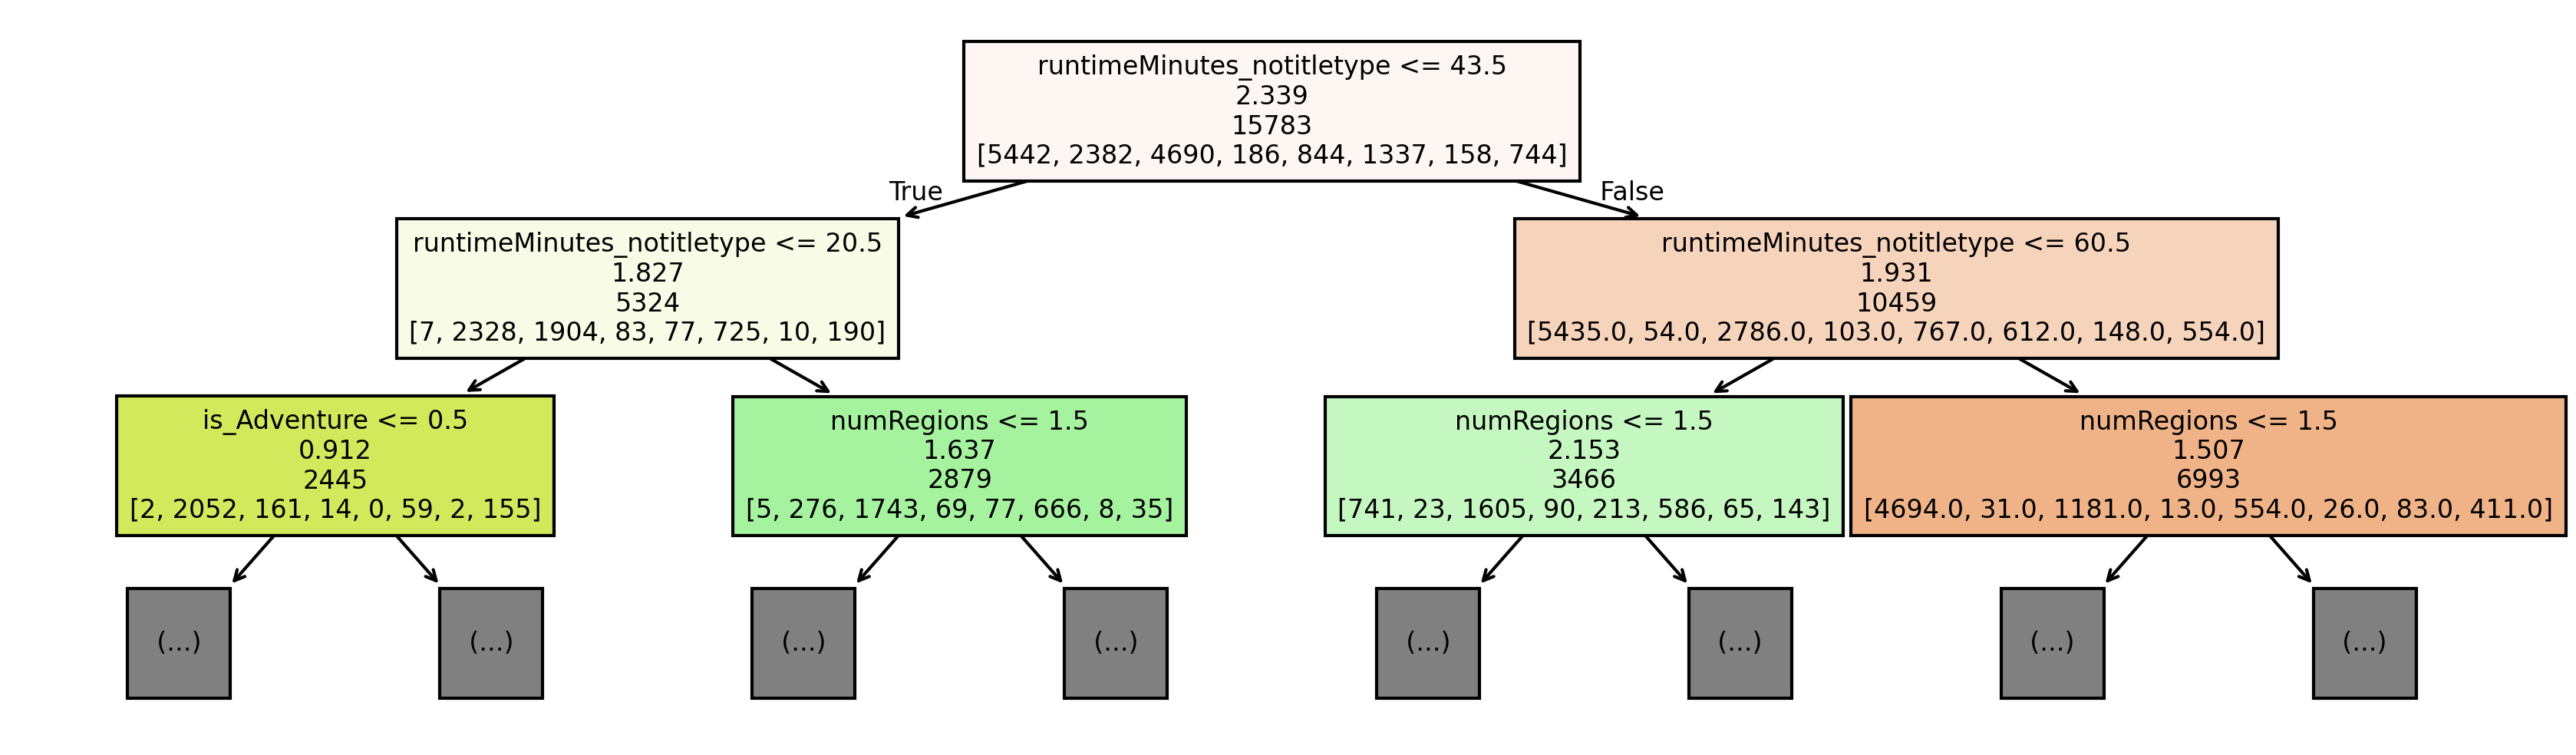

In [28]:
from sklearn.tree import plot_tree

plt.figure(figsize=(14, 4), dpi=300)
# plot_tree(random_search.best_estimator_, feature_names=feats, filled=True,
#           max_depth=2, fontsize=8, impurity=True, proportion=True)

plot_tree(
    random_search.best_estimator_,
    feature_names=feats,
    filled=True,
    max_depth=2,
    fontsize=8,
    impurity=True,
    proportion=False,
    label='none'  # Prevent default labels
)
plt.show()